# Anomaly Detection Project
By Jeff Akins

### ![](https://mk0crunchmetric1ct0g.kinstacdn.com/wp-content/uploads/2019/10/Anomaly-detection-on-time-series-data-with-auto-encoders.jpg)

#### Imports:

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
import prepare as prep

#### Data is prepped in the prepare.py file and retrived in the next line:

In [2]:
log = prep.prep_logs()

#### Initial Data Exploration:

In [3]:
log.head()

,path,user_id,cohort_id,ip,name,slack,start_date,end_date,created_at,updated_at,program_id,course_name,course_subdomain,hour,weekday
timestamp,,,,,,,,,,,,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,PHP Full Stack Web Dev,php,9,Friday
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,PHP Full Stack Web Dev,php,9,Friday
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,PHP Full Stack Web Dev,php,9,Friday
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,PHP Full Stack Web Dev,php,9,Friday
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2,Java Full Stack Web Dev,java,9,Friday


In [4]:
log.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 900223 entries, 2018-01-26 09:55:03 to 2021-04-21 16:44:39
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   path              900222 non-null  object        
 1   user_id           900223 non-null  int64         
 2   cohort_id         900223 non-null  int64         
 3   ip                900223 non-null  object        
 4   name              900223 non-null  object        
 5   slack             900223 non-null  object        
 6   start_date        900223 non-null  datetime64[ns]
 7   end_date          900223 non-null  datetime64[ns]
 8   created_at        900223 non-null  datetime64[ns]
 9   updated_at        900223 non-null  datetime64[ns]
 10  program_id        900223 non-null  int64         
 11  course_name       900223 non-null  object        
 12  course_subdomain  900223 non-null  object        
 13  hour              900223 

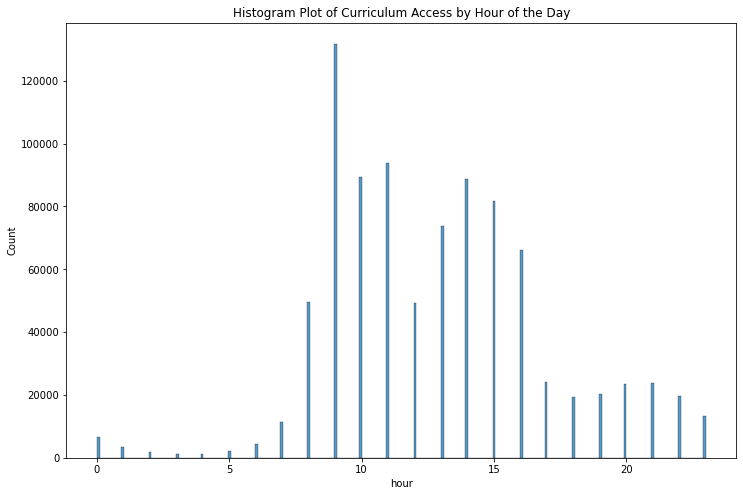

In [5]:
# Histogram Plot of Curriculum Access by Hour of the Day
plt.figure(figsize=(12, 8))
sns.histplot(data=log,
    x="hour", palette="ch:s=.25,rot=-.25",)
plt.title('Histogram Plot of Curriculum Access by Hour of the Day')
plt.show()

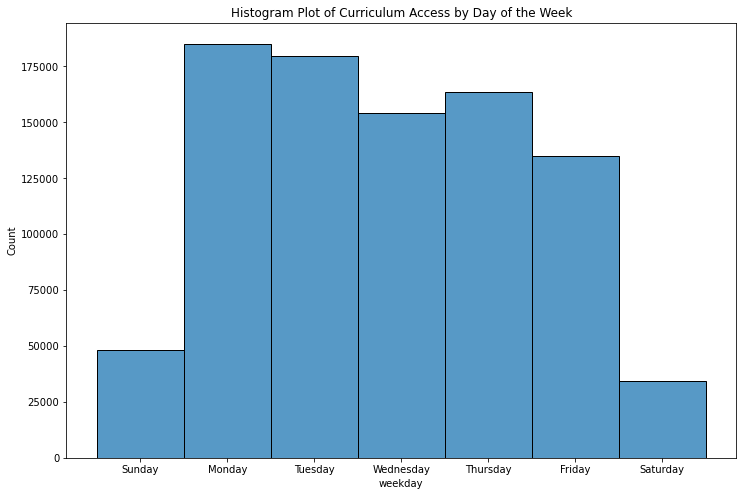

In [6]:
# Histogram Plot of Curriculum Access by Day of the Week
plt.figure(figsize=(12, 8))
sns.histplot(data=log,
    x="weekday", palette="ch:s=.25,rot=-.25",)
plt.title('Histogram Plot of Curriculum Access by Day of the Week')
plt.show()

## Questions

### 1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?

In [48]:
log.head(1)

,path,user_id,cohort_id,ip,name,slack,start_date,end_date,created_at,updated_at,program_id,course_name,course_subdomain,hour,weekday
timestamp,,,,,,,,,,,,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,PHP Full Stack Web Dev,php,9,Friday


In [8]:
# Removing all paths that are not a lesson
lesson = log.copy()
lesson = lesson[lesson.path.str.endswith('jpg') == False]
lesson = lesson[lesson.path.str.endswith('jpeg') == False]
lesson = lesson[lesson.path.str.endswith('svg') == False]
lesson = lesson[(lesson.path != '/') & (lesson.path != 'search/search_index.json') 
                & (lesson.path != 'toc') & (lesson.path != 'appendix')]

In [12]:
# List of top 20 lessons across all cohorts:
top_lessons = pd.DataFrame(lesson.path.value_counts().head(20))
top_lessons

,path
javascript-i,18983
java-iii,13733
html-css,13635
java-ii,12685
spring,12524
jquery,11525
mysql,11033
java-i,10865
javascript-ii,10730
javascript-i/introduction/working-with-data-types-operators-and-variables,7642


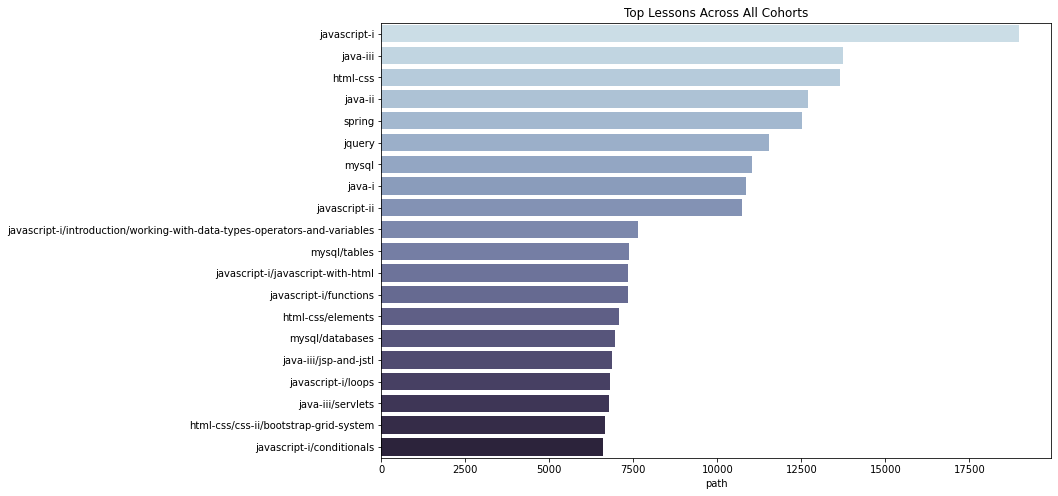

In [11]:
# Plot of top 20 lessons across all cohorts:
plt.figure(figsize=(12, 8))
sns.barplot(data=top_lessons,
    x="path", y=top_lessons.index, palette="ch:s=.25,rot=-.25", )
plt.title('Top Lessons Across All Cohorts')
plt.show()

##### Top Five Lessons for Each Program

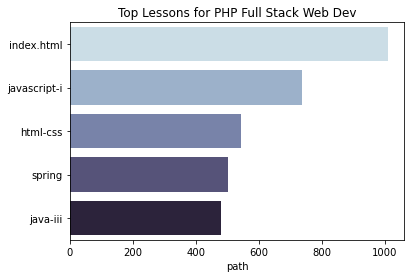

,path
index.html,1011
javascript-i,736
html-css,542
spring,501
java-iii,479


In [58]:
# Top lessons for PHP Web Dev
top_course_lessons = pd.DataFrame(lesson[lesson.course_subdomain == 'php'].path.value_counts().head(5))
plt.figure(figsize=(6, 4))
sns.barplot(data=top_course_lessons,
x="path", y=top_course_lessons.index, palette="ch:s=.25,rot=-.25", )
plt.title('Top Lessons for PHP Full Stack Web Dev')
plt.show()
top_course_lessons

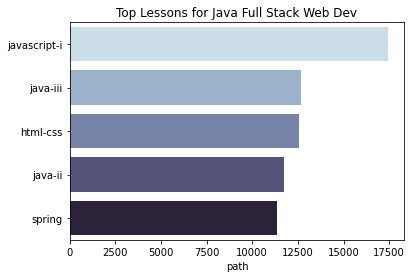

,path
javascript-i,17457
java-iii,12683
html-css,12569
java-ii,11719
spring,11376


In [57]:
# Top lessons for Java Full Stack Web Dev
top_course_lessons = pd.DataFrame(lesson[lesson.course_subdomain == 'java'].path.value_counts().head(5))
plt.figure(figsize=(6, 4))
sns.barplot(data=top_course_lessons,
x="path", y=top_course_lessons.index, palette="ch:s=.25,rot=-.25", )
plt.title('Top Lessons for Java Full Stack Web Dev')
plt.show()
top_course_lessons

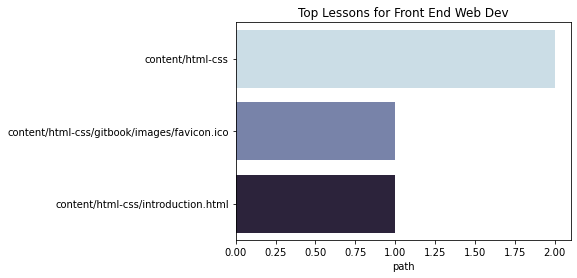

,path
content/html-css,2
content/html-css/gitbook/images/favicon.ico,1
content/html-css/introduction.html,1


In [56]:
# Top lessons for Front End Web Dev
top_course_lessons = pd.DataFrame(lesson[lesson.course_subdomain == 'fe'].path.value_counts().head(5))
plt.figure(figsize=(6, 4))
sns.barplot(data=top_course_lessons,
x="path", y=top_course_lessons.index, palette="ch:s=.25,rot=-.25", )
plt.title('Top Lessons for Front End Web Dev')
plt.show()
top_course_lessons

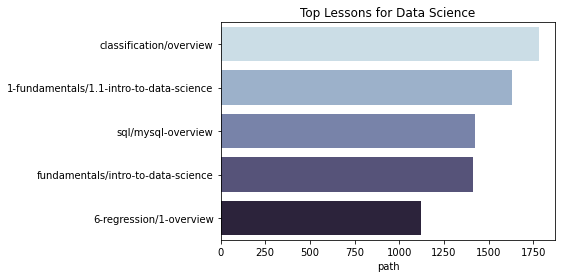

,path
classification/overview,1785
1-fundamentals/1.1-intro-to-data-science,1633
sql/mysql-overview,1424
fundamentals/intro-to-data-science,1413
6-regression/1-overview,1124


In [55]:
# Top lessons for Data Science
top_course_lessons = pd.DataFrame(lesson[lesson.course_subdomain == 'ds'].path.value_counts().head(5))
plt.figure(figsize=(6, 4))
sns.barplot(data=top_course_lessons,
x="path", y=top_course_lessons.index, palette="ch:s=.25,rot=-.25", )
plt.title('Top Lessons for Data Science')
plt.show()
top_course_lessons

#### Findings:
Java Full Stack Web Dev is by far the largest course and accesses the following courses the most:
1. javascript-i
2. java-iii
3. html-css

For PHP Full Stack Web Dev it was:
1. index.html
2. javascript-i
3. html-css

For the few Front End Web Dev students it was:
1. content/html-css
2. content/html-css/gitbook/images/favicon.ico
3. content/html-css/introduction.html

For Data Science it was:
1. classification/overview
2. 1-fundamentals/1.1-intro-to-data-science
3. sql/mysql-overview

### 2. Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?

In [59]:
lesson.head(1)

,path,user_id,cohort_id,ip,name,slack,start_date,end_date,created_at,updated_at,program_id,course_name,course_subdomain,hour,weekday
timestamp,,,,,,,,,,,,,,,
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,PHP Full Stack Web Dev,php,9,Friday


In [77]:
cohort_keys = lesson.name.unique()
cohort_keys

array(['Hampton', 'Teddy', 'Sequoia', 'Arches', 'Niagara', 'Pinnacles',
       'Quincy', 'none', 'Kings', 'Lassen', 'Mammoth', 'Glacier',
       'Denali', 'Joshua', 'Olympic', 'Ulysses', 'Badlands', 'Apollo',
       'Ike', 'Voyageurs', 'Wrangell', 'Xanadu', 'Franklin', 'Yosemite',
       'Staff', 'Zion', 'Andromeda', 'Betelgeuse', 'Ceres', 'Bayes',
       'Deimos', 'Europa', 'Fortuna', 'Curie', 'Apex', 'Ganymede',
       'Hyperion', 'Darden', 'Bash', 'Jupiter', 'Kalypso', 'Luna',
       'Easley', 'Marco', 'Florence', 'Neptune', 'Oberon'], dtype=object)

In [100]:
# For loop to gather the top five lessons for each cohort
list_of_cohorts = []
cohort_keys = lesson.name.unique()

for keys in cohort_keys:
    cohorts = pd.DataFrame(lesson[lesson.name == keys].path.value_counts().head(5))
    list_of_cohorts.append(cohorts)

In [107]:
# Dataframe with all of the cohorts top five lessons!
top_cohort_lesson = pd.concat(list_of_cohorts, keys=cohort_keys, names=['cohort', 'lesson'])
top_cohort_lesson.head(10)

path
cohort  lesson                        
Hampton java-iii                    57
        java-i                      46
        java-ii                     46
        spring                      43
        javascript-i                36
Teddy   spring                     744
        java-iii                   732
        mysql                      638
        javascript-i               615
        mkdocs/search_index.json   595

In [152]:
tcl = top_cohort_lesson.reset_index(level=[0,1])
tcl.head()

,cohort,lesson,path
0,Hampton,java-iii,57
1,Hampton,java-i,46
2,Hampton,java-ii,46
3,Hampton,spring,43
4,Hampton,javascript-i,36


In [ ]:

plt.figure(figsize=(10, 200))
sns.barplot(data=tcl, x="path", y="cohort", 
            hue="lesson", palette="Paired", )
plt.title('Top Lessons for Data Science')
plt.show()

#### Findings:
Darden went to the "Stats/compare-means" page more than other Data Science coorts


### 5. At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?


### 6. What topics are grads continuing to reference after graduation and into their jobs (for each program)?


### 7. Which lessons are least accessed?